https://www.kaggle.com/aryaprince/getting-started-with-object-detection-with-pytorch/?

## EDA

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from PIL import Image
import cv2
import os
import re

In [2]:
data_path = '../../data/wheat_detection/'

df_train = pd.read_csv(data_path + 'train.csv')
df_sub = pd.read_csv(data_path + 'sample_submission.csv')

In [3]:
df_train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [4]:
df_train = df_train.drop(columns=['width', 'height', 'source'])
df_train.head()

,image_id,bbox
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]"
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]"
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]"
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]"
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]"


In [5]:
len(df_train['image_id'].unique())

3373

In [6]:
aa = df_train['bbox'].iloc[0]
aa

'[834.0, 222.0, 56.0, 36.0]'

In [7]:
bbox_list = df_train['bbox']
x1, y1, x2, y2 = [], [], [], []
for b in bbox_list:
    bbox = re.findall('([0-9]+[.]?[0-9]*)', b)
    x1.append(float(bbox[0]))
    y1.append(float(bbox[1]))
    x2.append(float(bbox[0]) + float(bbox[2]))
    y2.append(float(bbox[1]) + float(bbox[3]))

df_train['x1'] = x1
df_train['y1'] = y1
df_train['x2'] = x2
df_train['y2'] = y2

df_train.head()

,image_id,bbox,x1,y1,x2,y2
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]",834.0,222.0,890.0,258.0
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]",226.0,548.0,356.0,606.0
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]",377.0,504.0,451.0,664.0
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]",834.0,95.0,943.0,202.0
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]",26.0,144.0,150.0,261.0


In [8]:
image_ids = df_train['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

df_valid = df_train[df_train['image_id'].isin(valid_ids)]
df_train = df_train[df_train['image_id'].isin(train_ids)]

In [9]:
df_valid.head()

,image_id,bbox,x1,y1,x2,y2
122787,bbce58f71,"[430.0, 0.0, 142.0, 75.0]",430.0,0.0,572.0,75.0
122788,bbce58f71,"[255.0, 377.0, 100.0, 69.0]",255.0,377.0,355.0,446.0
122789,bbce58f71,"[788.0, 634.0, 146.0, 77.0]",788.0,634.0,934.0,711.0
122790,bbce58f71,"[344.0, 836.0, 102.0, 110.0]",344.0,836.0,446.0,946.0
122791,bbce58f71,"[217.0, 694.0, 107.0, 85.0]",217.0,694.0,324.0,779.0


In [10]:
df_train.head()

,image_id,bbox,x1,y1,x2,y2
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]",834.0,222.0,890.0,258.0
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]",226.0,548.0,356.0,606.0
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]",377.0,504.0,451.0,664.0
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]",834.0,95.0,943.0,202.0
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]",26.0,144.0,150.0,261.0


(-0.5, 1023.5, 1023.5, -0.5)

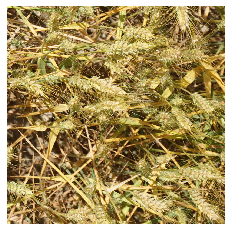

In [11]:
import glob
image_list = glob.glob(data_path + 'train/*.jpg')
sample = Image.open(image_list[0])
plt.imshow(sample)
plt.axis('off')

## Dataset

In [99]:
class wheatdataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        
        self.image_ids = self.dataframe['image_id'].unique()
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        img = Image.open(self.image_dir + image_id + '.jpg')
        img = np.array(img) / 255.
      
    
   #     img = cv2.imread(self.image_dir + image_id + '.jpg')
   #     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
   #     img /= 255.0
        
        if self.transform:
            img = self.transform(img)
            
        
        boxes = self.dataframe.loc[self.dataframe['image_id'] == image_id, ['x1','y1','x2','y2']]
        boxes = np.array(boxes)
        boxes = torch.from_numpy(boxes).type(torch.float32)
        
        labels = torch.ones((boxes.shape[0])).type(torch.int32)
        
        targets = {}
        targets['boxes'] = boxes
        targets['labels'] = labels
        
        return img, targets
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [100]:
TRAIN_DIR = '../../data/wheat_detection/train/'
TEST_DIR = '../../data/wheat_detection/test/'

transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = wheatdataset(df_train, TRAIN_DIR, transform=transform)
print(len(train_data))
trainloader = DataLoader(train_data, batch_size=1, collate_fn=collate_fn)
iter(trainloader).next()

2708


((tensor([[[0.1020, 0.1176, 0.1412,  ..., 0.2824, 0.2902, 0.2980],
           [0.0941, 0.1059, 0.1294,  ..., 0.2667, 0.2706, 0.2706],
           [0.0824, 0.0941, 0.1137,  ..., 0.2588, 0.2588, 0.2588],
           ...,
           [0.2196, 0.2196, 0.2196,  ..., 0.8667, 0.8745, 0.8667],
           [0.2353, 0.2314, 0.2275,  ..., 0.7882, 0.8078, 0.8196],
           [0.2471, 0.2431, 0.2392,  ..., 0.7176, 0.7294, 0.7529]],
  
          [[0.0941, 0.1098, 0.1333,  ..., 0.3804, 0.3804, 0.3765],
           [0.0863, 0.0980, 0.1216,  ..., 0.3608, 0.3608, 0.3608],
           [0.0745, 0.0863, 0.1059,  ..., 0.3529, 0.3529, 0.3529],
           ...,
           [0.2196, 0.2196, 0.2196,  ..., 0.8157, 0.8353, 0.8275],
           [0.2353, 0.2314, 0.2275,  ..., 0.7373, 0.7608, 0.7804],
           [0.2471, 0.2431, 0.2392,  ..., 0.6667, 0.6824, 0.7137]],
  
          [[0.0980, 0.1137, 0.1373,  ..., 0.2667, 0.2667, 0.2667],
           [0.0902, 0.1020, 0.1255,  ..., 0.2588, 0.2510, 0.2510],
           [0.0784, 0.

In [101]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [102]:
images, targets = iter(trainloader).next()
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


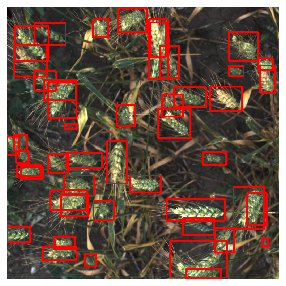

In [104]:
import matplotlib.pyplot as plt
import cv2

boxes = targets[0]['boxes'].numpy()
sample = images[0].permute(1,2,0).numpy()

fig, ax = plt.subplots(1, figsize=(5,5))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (255, 0, 0),
                  6)
    
ax.set_axis_off()
plt.imshow(sample)

## Model

In [105]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [106]:
num_classes = 2 # background & wheat

in_features = model.roi_heads.box_predictor.cls_score.in_features
in_features

1024

In [107]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [108]:
model.load_state_dict(torch.load('../../data/wheat_detection/fasterrcnn_resnet50_fpn_best.pth'))

<All keys matched successfully>

In [115]:
images = [img.to(device) for img in tuple(images)]

In [118]:
images

[tensor([[[0.1020, 0.1176, 0.1412,  ..., 0.2824, 0.2902, 0.2980],
          [0.0941, 0.1059, 0.1294,  ..., 0.2667, 0.2706, 0.2706],
          [0.0824, 0.0941, 0.1137,  ..., 0.2588, 0.2588, 0.2588],
          ...,
          [0.2196, 0.2196, 0.2196,  ..., 0.8667, 0.8745, 0.8667],
          [0.2353, 0.2314, 0.2275,  ..., 0.7882, 0.8078, 0.8196],
          [0.2471, 0.2431, 0.2392,  ..., 0.7176, 0.7294, 0.7529]],
 
         [[0.0941, 0.1098, 0.1333,  ..., 0.3804, 0.3804, 0.3765],
          [0.0863, 0.0980, 0.1216,  ..., 0.3608, 0.3608, 0.3608],
          [0.0745, 0.0863, 0.1059,  ..., 0.3529, 0.3529, 0.3529],
          ...,
          [0.2196, 0.2196, 0.2196,  ..., 0.8157, 0.8353, 0.8275],
          [0.2353, 0.2314, 0.2275,  ..., 0.7373, 0.7608, 0.7804],
          [0.2471, 0.2431, 0.2392,  ..., 0.6667, 0.6824, 0.7137]],
 
         [[0.0980, 0.1137, 0.1373,  ..., 0.2667, 0.2667, 0.2667],
          [0.0902, 0.1020, 0.1255,  ..., 0.2588, 0.2510, 0.2510],
          [0.0784, 0.0902, 0.1098,  ...,

In [120]:
model.eval()

with torch.no_grad():
    model = model.to(device).double()
    outputs = model(images)